### Data Loading and Feature Engineering

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import warnings
import numpy as np
import logging
from pathlib import Path
import gdown
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)

In [18]:
#pip install catboost

In [19]:
#pip install lightgbm

In [20]:
#pip install xgboost

In [21]:
#pip install optuna

In [22]:
#pip install optuna plotly

In [9]:
df.columns

Index(['homeid', 'electric_min_consumption', 'electric_max_consumption',
       'electric_std_consumption', 'electric_median_consumption',
       'electric_total_consumption_kWh', 'gas_mean_consumption',
       'gas_min_consumption', 'gas_max_consumption', 'gas_median_consumption',
       'gas_total_consumption_kWh', 'median_value_temp_room', 'roomid',
       'income_band_mid', 'education_map', 'day', 'month', 'year', 'hour',
       'electric_lag_1', 'gas_lag_1'],
      dtype='object')

In [2]:
def clean_data(df):
    """Clean, preprocess and engineer feature of sensor data"""

    # Sort by homeid and timestamp_local
    df = df.sort_values(by=['homeid', 'timestamp_local'])

    # Extract Day, Month, Year, Hour and Minute as new columns
    df['day'] = df['timestamp_local'].dt.day
    df['month'] = df['timestamp_local'].dt.month
    df['year'] = df['timestamp_local'].dt.year
    df['hour'] = df['timestamp_local'].dt.hour

    df = df.rename(columns={'median_value': 'median_value_temp_room',
                            'std_consumption': 'electric_std_consumption',
                            'electric_total_consumption_Wh': 'electric_total_consumption_kWh',
                            'gas_total_consumption_Wh': 'gas_total_consumption_kWh' })
    
    gas_columns = [col for col in df.columns if 'gas' in col.lower()]
    print(gas_columns)
    for col in gas_columns:
        df = df[df[col] >= 0]

    # create lagged values for energy and gas consumption
    df['electric_lag_1'] = df.groupby('homeid')['electric_total_consumption_kWh'].shift(1)
    df['gas_lag_1'] = df.groupby('homeid')['gas_total_consumption_kWh'].shift(1)

    df['electric_lag_1'] = df['electric_lag_1'].fillna(0)
    df['gas_lag_1'] = df['gas_lag_1'].fillna(0)

    scaled_features = ['electric_total_consumption_kWh', 'gas_total_consumption_kWh',
                       'electric_median_consumption', 'electric_max_consumption',
                       'electric_min_consumption', 'electric_std_consumption', 'gas_max_consumption', 
                       'gas_min_consumption', 'gas_median_consumption', 'median_value_temp_room', 
                       'electric_lag_1', 'gas_lag_1']

    # Initialize scaler
    scaler = MinMaxScaler()

    # Fit and transform the selected features
    df[scaled_features] = scaler.fit_transform(df[scaled_features])

    # Remove specified columns
    columns_to_drop = [
        'sensorid', 'median_temperature', '_room',
        'sensorid_room', 'measured_entity',
        'sensorid_electric', 'sensorid_gas', 'timestamp_local'
    ]

    df = df.drop(columns=columns_to_drop)

    return df

def load_processed_data():
    """Load preprocessed sensor data with fallback to Drive download"""
    file_id = "1KHQCVfwTxm5bjjITS8WMm9P3M12ETVsR"

    download_path = Path('data/processed')
    download_path.mkdir(parents=True, exist_ok=True)
    file_path = download_path / 'final_processed_data3.parquet'

    if not file_path.exists():
        print("Downloading from Google Drive...")
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, str(file_path), quiet=False)

    if file_path.exists():
        df = pd.read_parquet(file_path)
        print(f"Data loaded successfully: {df.shape} rows")
        return df
    else:
        raise FileNotFoundError("Could not load or download data file")

# Load and clean data
df = clean_data(load_processed_data().copy())

Data loaded successfully: (1641653, 23) rows
['sensorid_gas', 'gas_mean_consumption', 'gas_min_consumption', 'gas_max_consumption', 'gas_median_consumption', 'gas_total_consumption_kWh']


In [ ]:
print(df.shape)

(1641639, 21)


## 1 - Correct Hyperparameter Method for energy consumption

In [4]:
import optuna
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import gc

# Regressors
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestRegressor

# Sample data 
X_elec = df.drop(columns=['electric_total_consumption_kWh'])
y_elec = df['electric_total_consumption_kWh']

# Progress bar callback
class ProgressCallback:
    def __init__(self, n_trials):
        self.pbar = tqdm(total=n_trials)

    def __call__(self, study, trial): 
        self.pbar.update(1)

MODEL_PARAMS = {
    "randomforest": {
        "n_estimators": [5, 10, 15, 20, 25],
        "min_samples_split": [2,3, 4, 6, 8, 10],
        "max_features": ["sqrt", "log2"]
    },
    "lightgbm": {
        "n_estimators": [10, 20, 30, 40],
        "learning_rate": [0.001, 0.01, 0.1],
        "max_depth": [3, 5, 7, 10],
        "reg_lambda": [0, 0.1, 1, 5, 10]
    },
    "xgboost": {
        "n_estimators": [10, 20, 30, 40],
        "learning_rate": [0.001, 0.01, 0.1],
        "max_depth": [3, 5, 7, 10],
        "reg_lambda": [0, 0.1, 1, 5, 10]
    },
    "catboost": {
        "n_estimators": [10, 20, 30, 40],
        "learning_rate": [0.001, 0.01, 0.1],
        "max_depth": [3, 5, 7, 10],
        "reg_lambda": [0, 0.1, 1, 5, 10]
    },

}

MODEL_CONSTRUCTORS = {
    "lightgbm": lambda params: lgb.LGBMRegressor(**params, random_state=42, verbose=-1),
    "xgboost":  lambda params: xgb.XGBRegressor(**params, random_state=42, verbosity=0),
    "catboost": lambda params: cb.CatBoostRegressor(**params, random_seed=42, verbose=0),
    "randomforest": lambda params: RandomForestRegressor(**params, random_state=42, verbose=0)
}

def make_objective(X, y, model_name):
    """
    Returns an objective function that optimizes hyperparameters
    for the specified model_name using Optuna.
    """
    def objective(trial):
        # Get hyperparameter space for this model
        param_space = MODEL_PARAMS[model_name]
        
        # Create parameter dictionary
        params = {}
        for name, values in param_space.items():
            # If first item is string, pass directly; else convert to tuple
            if isinstance(values[0], str):
                params[name] = trial.suggest_categorical(name, values)
            else:
                params[name] = trial.suggest_categorical(name, tuple(values))
        
        model = MODEL_CONSTRUCTORS[model_name](params)

        # TimeSeriesSplit for temporal data
        tscv = TimeSeriesSplit(n_splits=3)

        val_mse_list = []
        test_mse_list = []
        test_rmse_list = []
        test_mae_list = []
        test_r2_list = []

        for train_index, eval_index in tscv.split(X):
            n_eval = len(eval_index)
            if n_eval < 2:
                continue
            split_point = int(n_eval * 0.5)
            val_index = eval_index[:split_point]
            test_index = eval_index[split_point:]

            X_train = X.iloc[train_index]
            X_val   = X.iloc[val_index]
            X_test  = X.iloc[test_index]
            y_train = y.iloc[train_index]
            y_val   = y.iloc[val_index]
            y_test  = y.iloc[test_index]

            model.fit(X_train, y_train)

            y_val_pred = model.predict(X_val)
            val_mse_list.append(mean_squared_error(y_val, y_val_pred))

            y_test_pred = model.predict(X_test)
            mse_test = mean_squared_error(y_test, y_test_pred)
            mae_test = mean_absolute_error(y_test, y_test_pred)
            rmse_test = np.sqrt(mse_test)
            r2_test = r2_score(y_test, y_test_pred)

            test_mse_list.append(mse_test)
            test_rmse_list.append(rmse_test)
            test_mae_list.append(mae_test)
            test_r2_list.append(r2_test)

        avg_val_mse  = np.mean(val_mse_list)
        avg_test_mse = np.mean(test_mse_list) if test_mse_list else np.nan
        avg_test_rmse = np.mean(test_rmse_list) if test_rmse_list else np.nan
        avg_test_mae = np.mean(test_mae_list) if test_mae_list else np.nan
        avg_test_r2  = np.mean(test_r2_list) if test_r2_list else np.nan

        # Store metrics
        trial.set_user_attr("avg_test_mse", avg_test_mse)
        trial.set_user_attr("avg_test_rmse", avg_test_rmse)
        trial.set_user_attr("avg_test_mae", avg_test_mae)
        trial.set_user_attr("avg_test_r2", avg_test_r2)

        return avg_val_mse

    return objective

# Create one study per model.
models = ["lightgbm", "xgboost", "catboost", "randomforest"]
studies = {}
n_trials = 40

print("-"*30 + "Electric Consumption" + "-"*30)

for m in models:
    print(f"Starting study for: {m}")
    # Each model gets its own study
    study = optuna.create_study(direction="minimize")
    progress_callback = ProgressCallback(n_trials)
    study.optimize(
        make_objective(X_elec, y_elec, m),
        n_trials=n_trials,
        callbacks=[progress_callback]
    )
    gc.collect()
    studies[m] = study
    print(f"Finished study for: {m}")
    print("-"*60)

# Compare best trials from each separate study
print("\nBest Trials Per Model:")
for model_name, study in studies.items():
    best_trial = min(study.trials, key=lambda t: t.value)
    print(f"\nModel: {model_name}")
    print(f"  Best Validation MSE: {best_trial.value:.4f}")
    print("  Test Metrics (averaged across folds):")
    print(f"    RMSE: {best_trial.user_attrs.get('avg_test_rmse', np.nan):.4f}")
    print(f"    R2:   {best_trial.user_attrs.get('avg_test_r2', np.nan):.4f}")
    print(f"    MAE:  {best_trial.user_attrs.get('avg_test_mae', np.nan):.4f}")
    print(f"    MSE:  {best_trial.user_attrs.get('avg_test_mse', np.nan):.4f}")
    print("  Hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

[I 2025-02-16 16:49:40,014] A new study created in memory with name: no-name-3dbc8bff-7f13-43ea-a9aa-2caf4c4ffa25


------------------------------Electric Consumption------------------------------
Starting study for: lightgbm


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-02-16 16:49:45,440] Trial 0 finished with value: 8.093636949369852e-05 and parameters: {'n_estimators': 40, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 1}. Best is trial 0 with value: 8.093636949369852e-05.
[I 2025-02-16 16:49:49,247] Trial 1 finished with value: 0.001733525092919295 and parameters: {'n_estimators': 20, 'learning_rate': 0.001, 'max_depth': 7, 'reg_lambda': 1}. Best is trial 0 with value: 8.093636949369852e-05.
[I 2025-02-16 16:49:53,247] Trial 2 finished with value: 0.00010156927350503515 and parameters: {'n_estimators': 40, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0}. Best is trial 0 with value: 8.093636949369852e-05.
[I 2025-02-16 16:49:57,308] Trial 3 finished with value: 0.001768368584429578 and parameters: {'n_estimators': 10, 'learning_rate': 0.001, 'max_depth': 3, 'reg_lambda': 0}. Best is trial 0 with value: 8.093636949369852e-05.
[I 2025-02-16 16:50:03,148] Trial 4 finished with value: 7.708255581110591e-05 and parameters: {'n_estima

Finished study for: lightgbm
------------------------------------------------------------
Starting study for: xgboost


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-02-16 16:53:06,477] Trial 0 finished with value: 8.433733645623335e-05 and parameters: {'n_estimators': 40, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0}. Best is trial 0 with value: 8.433733645623335e-05.
[I 2025-02-16 16:53:19,396] Trial 1 finished with value: 7.110334153212512e-05 and parameters: {'n_estimators': 30, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 5}. Best is trial 1 with value: 7.110334153212512e-05.
[I 2025-02-16 16:53:27,718] Trial 2 finished with value: 0.0011677553647365987 and parameters: {'n_estimators': 30, 'learning_rate': 0.01, 'max_depth': 3, 'reg_lambda': 1}. Best is trial 1 with value: 7.110334153212512e-05.
[I 2025-02-16 16:53:37,237] Trial 3 finished with value: 0.00010257116781218638 and parameters: {'n_estimators': 40, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 10}. Best is trial 1 with value: 7.110334153212512e-05.
[I 2025-02-16 16:53:51,375] Trial 4 finished with value: 0.0017337414227168947 and parameters: {'n_estima

Finished study for: xgboost
------------------------------------------------------------
Starting study for: catboost


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-02-16 17:02:10,953] Trial 0 finished with value: 0.0010584439220035012 and parameters: {'n_estimators': 40, 'learning_rate': 0.01, 'max_depth': 3, 'reg_lambda': 10}. Best is trial 0 with value: 0.0010584439220035012.
[I 2025-02-16 17:02:19,221] Trial 1 finished with value: 9.209184906035224e-05 and parameters: {'n_estimators': 30, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 5}. Best is trial 1 with value: 9.209184906035224e-05.
[I 2025-02-16 17:02:27,390] Trial 2 finished with value: 0.0016811572225700492 and parameters: {'n_estimators': 40, 'learning_rate': 0.001, 'max_depth': 5, 'reg_lambda': 1}. Best is trial 1 with value: 9.209184906035224e-05.
[I 2025-02-16 17:02:42,324] Trial 3 finished with value: 8.718843309667939e-05 and parameters: {'n_estimators': 30, 'learning_rate': 0.1, 'max_depth': 10, 'reg_lambda': 10}. Best is trial 3 with value: 8.718843309667939e-05.
[I 2025-02-16 17:02:50,460] Trial 4 finished with value: 0.0010849498524688097 and parameters: {'n_est

Finished study for: catboost
------------------------------------------------------------
Starting study for: randomforest


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-02-16 17:10:42,528] Trial 0 finished with value: 0.00017539268361397862 and parameters: {'n_estimators': 5, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.00017539268361397862.
[I 2025-02-16 17:15:01,499] Trial 1 finished with value: 0.00010468517152824601 and parameters: {'n_estimators': 25, 'min_samples_split': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.00010468517152824601.
[I 2025-02-16 17:15:49,894] Trial 2 finished with value: 0.00013883575002895536 and parameters: {'n_estimators': 5, 'min_samples_split': 8, 'max_features': 'log2'}. Best is trial 1 with value: 0.00010468517152824601.
[I 2025-02-16 17:18:51,808] Trial 3 finished with value: 9.83106438336529e-05 and parameters: {'n_estimators': 20, 'min_samples_split': 10, 'max_features': 'sqrt'}. Best is trial 3 with value: 9.83106438336529e-05.
[I 2025-02-16 17:21:54,728] Trial 4 finished with value: 9.83106438336529e-05 and parameters: {'n_estimators': 20, 'min_samples_split

Finished study for: randomforest
------------------------------------------------------------

Best Trials Per Model:

Model: lightgbm
  Best Validation MSE: 0.0001
  Test Metrics (averaged across folds):
    RMSE: 0.0079
    R2:   0.9596
    MAE:  0.0038
    MSE:  0.0001
  Hyperparameters:
    n_estimators: 40
    learning_rate: 0.1
    max_depth: 7
    reg_lambda: 10

Model: xgboost
  Best Validation MSE: 0.0001
  Test Metrics (averaged across folds):
    RMSE: 0.0076
    R2:   0.9632
    MAE:  0.0034
    MSE:  0.0001
  Hyperparameters:
    n_estimators: 40
    learning_rate: 0.1
    max_depth: 7
    reg_lambda: 0.1

Model: catboost
  Best Validation MSE: 0.0001
  Test Metrics (averaged across folds):
    RMSE: 0.0084
    R2:   0.9550
    MAE:  0.0043
    MSE:  0.0001
  Hyperparameters:
    n_estimators: 30
    learning_rate: 0.1
    max_depth: 10
    reg_lambda: 0

Model: randomforest
  Best Validation MSE: 0.0001
  Test Metrics (averaged across folds):
    RMSE: 0.0089
    R2:   0.

## 2 - Correct Hyperparameter Method for gas consumption

In [32]:
df.columns

Index(['homeid', 'electric_min_consumption', 'electric_max_consumption',
       'electric_std_consumption', 'electric_median_consumption',
       'electric_total_consumption_kWh', 'gas_mean_consumption',
       'gas_min_consumption', 'gas_max_consumption', 'gas_median_consumption',
       'gas_total_consumption_kWh', 'median_value_temp_room', 'roomid',
       'income_band_mid', 'education_map', 'day', 'month', 'year', 'hour',
       'electric_lag_1', 'gas_lag_1'],
      dtype='object')

In [5]:
X_gas = df.drop(columns=['gas_total_consumption_kWh'])
y_gas = df['gas_total_consumption_kWh']

# Create one study per model.
models2 = ["lightgbm", "xgboost", "catboost", "randomforest"]
studies2 = {}
n_trials = 40
print("-"*30 + "Gas Consumption" + "-"*30)

for m in models2:
    print(f"Starting study for: {m}")
    # Each model gets its own study
    study2 = optuna.create_study(direction="minimize")
    progress_callback = ProgressCallback(n_trials)
    study2.optimize(
        make_objective(X_gas, y_gas, m),
        n_trials=n_trials,
        callbacks=[progress_callback]
    )
    gc.collect()
    studies2[m] = study2
    print(f"Finished study for: {m}")
    print("-"*60)

# Compare best trials from each separate study
print("\nBest Trials Per Model:")
for model_name, study in studies2.items():
    best_trial2 = min(study.trials, key=lambda t: t.value)
    print(f"\nModel: {model_name}")
    print(f"  Best Validation MSE: {best_trial2.value:.4f}")
    print("  Test Metrics (averaged across folds):")
    print(f"    RMSE: {best_trial2.user_attrs.get('avg_test_rmse', np.nan):.4f}")
    print(f"    R2:   {best_trial2.user_attrs.get('avg_test_r2', np.nan):.4f}")
    print(f"    MAE:  {best_trial2.user_attrs.get('avg_test_mae', np.nan):.4f}")
    print(f"    MSE:  {best_trial2.user_attrs.get('avg_test_mse', np.nan):.4f}")
    print("  Hyperparameters:")
    for key, value in best_trial2.params.items():
        print(f"    {key}: {value}")

[I 2025-02-16 19:06:14,748] A new study created in memory with name: no-name-2f54c11a-8eba-4343-bd2d-b8ecfb55cef2


------------------------------Gas Consumption------------------------------
Starting study for: lightgbm


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-02-16 19:06:17,577] Trial 0 finished with value: 0.00021885111108528555 and parameters: {'n_estimators': 10, 'learning_rate': 0.001, 'max_depth': 7, 'reg_lambda': 10}. Best is trial 0 with value: 0.00021885111108528555.
[I 2025-02-16 19:06:20,967] Trial 1 finished with value: 2.073367480659376e-06 and parameters: {'n_estimators': 30, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0.1}. Best is trial 1 with value: 2.073367480659376e-06.
[I 2025-02-16 19:06:24,738] Trial 2 finished with value: 0.00021025518955302967 and parameters: {'n_estimators': 30, 'learning_rate': 0.001, 'max_depth': 7, 'reg_lambda': 1}. Best is trial 1 with value: 2.073367480659376e-06.
[I 2025-02-16 19:06:27,725] Trial 3 finished with value: 0.00012458613608747854 and parameters: {'n_estimators': 30, 'learning_rate': 0.01, 'max_depth': 3, 'reg_lambda': 1}. Best is trial 1 with value: 2.073367480659376e-06.
[I 2025-02-16 19:06:32,032] Trial 4 finished with value: 0.00020610413497211498 and parameters: 

Finished study for: lightgbm
------------------------------------------------------------
Starting study for: xgboost


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-02-16 19:08:47,941] Trial 0 finished with value: 0.00018218884906615905 and parameters: {'n_estimators': 10, 'learning_rate': 0.01, 'max_depth': 3, 'reg_lambda': 1}. Best is trial 0 with value: 0.00018218884906615905.
[I 2025-02-16 19:08:55,504] Trial 1 finished with value: 0.00012248408122894858 and parameters: {'n_estimators': 20, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 1}. Best is trial 1 with value: 0.00012248408122894858.
[I 2025-02-16 19:09:01,681] Trial 2 finished with value: 0.00018275190185646785 and parameters: {'n_estimators': 10, 'learning_rate': 0.01, 'max_depth': 5, 'reg_lambda': 1}. Best is trial 1 with value: 0.00012248408122894858.
[I 2025-02-16 19:09:09,437] Trial 3 finished with value: 0.00012142213661023978 and parameters: {'n_estimators': 30, 'learning_rate': 0.01, 'max_depth': 3, 'reg_lambda': 5}. Best is trial 3 with value: 0.00012142213661023978.
[I 2025-02-16 19:09:18,240] Trial 4 finished with value: 0.0001502672639976412 and parameters: {'

Finished study for: xgboost
------------------------------------------------------------
Starting study for: catboost


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-02-16 19:15:52,112] Trial 0 finished with value: 0.0002124997674957985 and parameters: {'n_estimators': 30, 'learning_rate': 0.001, 'max_depth': 10, 'reg_lambda': 10}. Best is trial 0 with value: 0.0002124997674957985.
[I 2025-02-16 19:16:00,429] Trial 1 finished with value: 3.5016985877654844e-06 and parameters: {'n_estimators': 40, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 1}. Best is trial 1 with value: 3.5016985877654844e-06.
[I 2025-02-16 19:16:05,671] Trial 2 finished with value: 0.0001248043409269928 and parameters: {'n_estimators': 30, 'learning_rate': 0.01, 'max_depth': 5, 'reg_lambda': 10}. Best is trial 1 with value: 3.5016985877654844e-06.
[I 2025-02-16 19:16:11,170] Trial 3 finished with value: 0.0002193600690368259 and parameters: {'n_estimators': 10, 'learning_rate': 0.001, 'max_depth': 10, 'reg_lambda': 0}. Best is trial 1 with value: 3.5016985877654844e-06.
[I 2025-02-16 19:16:14,212] Trial 4 finished with value: 0.000219082998652195 and parameters: {

Finished study for: catboost
------------------------------------------------------------
Starting study for: randomforest


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-02-16 19:23:55,917] Trial 0 finished with value: 3.6399898257742306e-06 and parameters: {'n_estimators': 20, 'min_samples_split': 4, 'max_features': 'log2'}. Best is trial 0 with value: 3.6399898257742306e-06.
[I 2025-02-16 19:29:11,596] Trial 1 finished with value: 6.837007379659377e-06 and parameters: {'n_estimators': 25, 'min_samples_split': 2, 'max_features': 'log2'}. Best is trial 0 with value: 3.6399898257742306e-06.
[I 2025-02-16 19:32:00,679] Trial 2 finished with value: 7.613141741705514e-06 and parameters: {'n_estimators': 15, 'min_samples_split': 10, 'max_features': 'log2'}. Best is trial 0 with value: 3.6399898257742306e-06.
[I 2025-02-16 19:34:50,934] Trial 3 finished with value: 2.229049731694987e-05 and parameters: {'n_estimators': 15, 'min_samples_split': 8, 'max_features': 'log2'}. Best is trial 0 with value: 3.6399898257742306e-06.
[I 2025-02-16 19:37:40,100] Trial 4 finished with value: 7.613141741705514e-06 and parameters: {'n_estimators': 15, 'min_samples_s

Finished study for: randomforest
------------------------------------------------------------

Best Trials Per Model:

Model: lightgbm
  Best Validation MSE: 0.0000
  Test Metrics (averaged across folds):
    RMSE: 0.0016
    R2:   0.9889
    MAE:  0.0005
    MSE:  0.0000
  Hyperparameters:
    n_estimators: 40
    learning_rate: 0.1
    max_depth: 7
    reg_lambda: 10

Model: xgboost
  Best Validation MSE: 0.0000
  Test Metrics (averaged across folds):
    RMSE: 0.0023
    R2:   0.9737
    MAE:  0.0006
    MSE:  0.0000
  Hyperparameters:
    n_estimators: 40
    learning_rate: 0.1
    max_depth: 3
    reg_lambda: 0

Model: catboost
  Best Validation MSE: 0.0000
  Test Metrics (averaged across folds):
    RMSE: 0.0019
    R2:   0.9834
    MAE:  0.0007
    MSE:  0.0000
  Hyperparameters:
    n_estimators: 40
    learning_rate: 0.1
    max_depth: 3
    reg_lambda: 1

Model: randomforest
  Best Validation MSE: 0.0000
  Test Metrics (averaged across folds):
    RMSE: 0.0020
    R2:   0.982

## Implementation of SHAP

### Calculate shap_values for electric


Best Trials Per Model:

Model: lightgbm
  Best Validation MSE: 0.0001
  Test Metrics (averaged across folds):
    RMSE: 0.0079
    R2:   0.9596
    MAE:  0.0038
    MSE:  0.0001
  Hyperparameters:
    n_estimators: 40
    learning_rate: 0.1
    max_depth: 7
    reg_lambda: 10


SHAP for lightgbm:   0%|          | 0/6 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

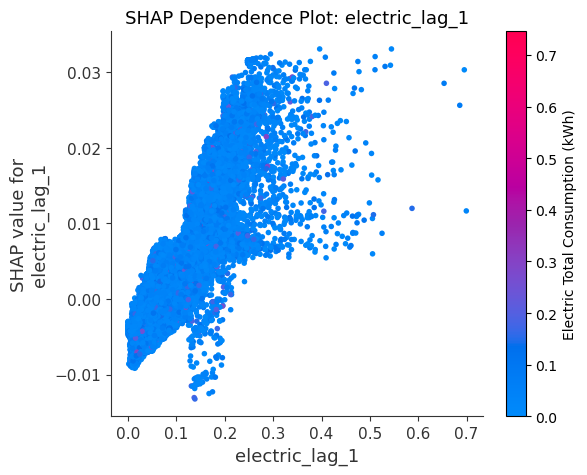

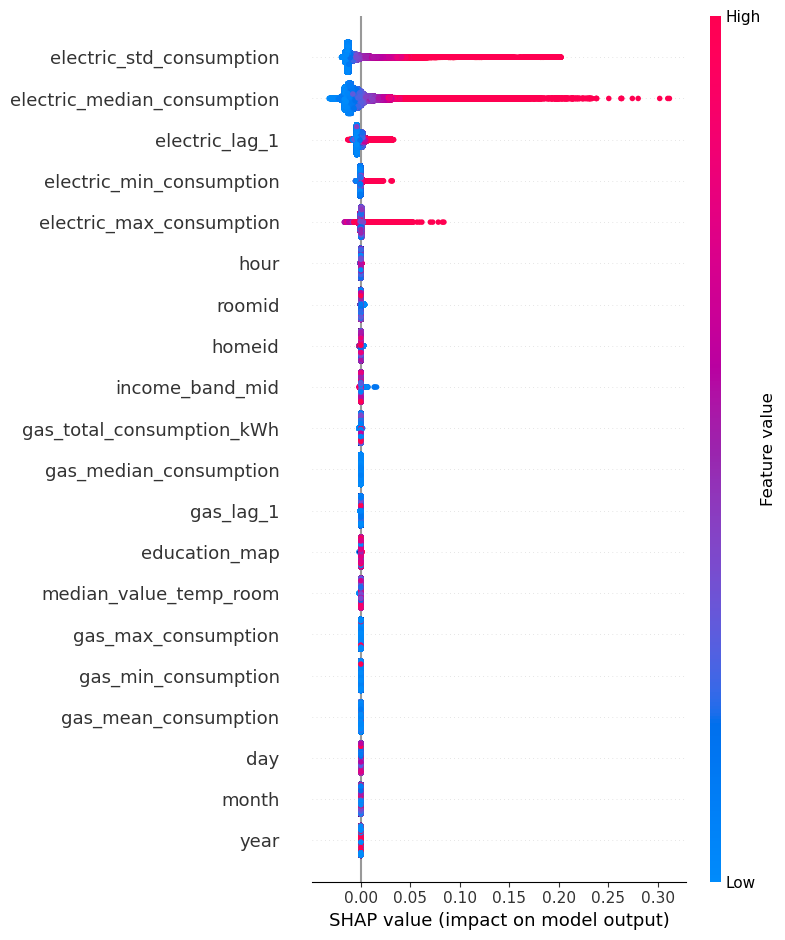

<Figure size 1000x600 with 0 Axes>

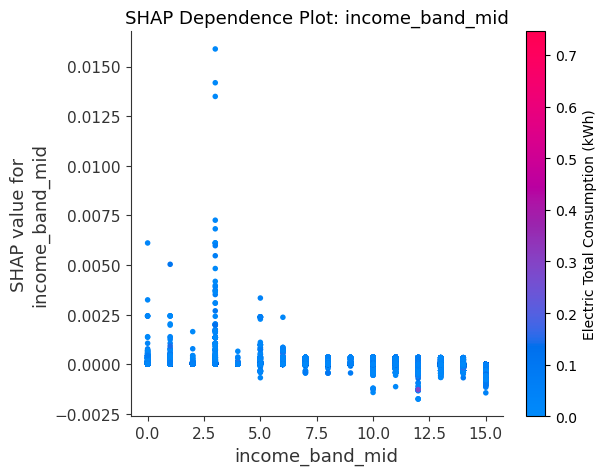

<Figure size 1000x600 with 0 Axes>

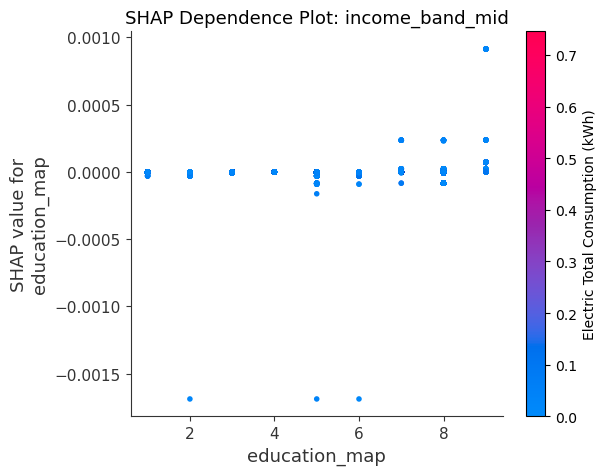


Model: xgboost
  Best Validation MSE: 0.0001
  Test Metrics (averaged across folds):
    RMSE: 0.0076
    R2:   0.9632
    MAE:  0.0034
    MSE:  0.0001
  Hyperparameters:
    n_estimators: 40
    learning_rate: 0.1
    max_depth: 7
    reg_lambda: 0.1


SHAP for xgboost:   0%|          | 0/6 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

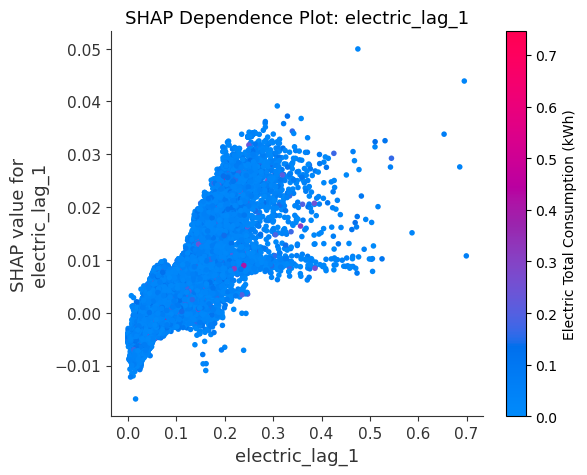

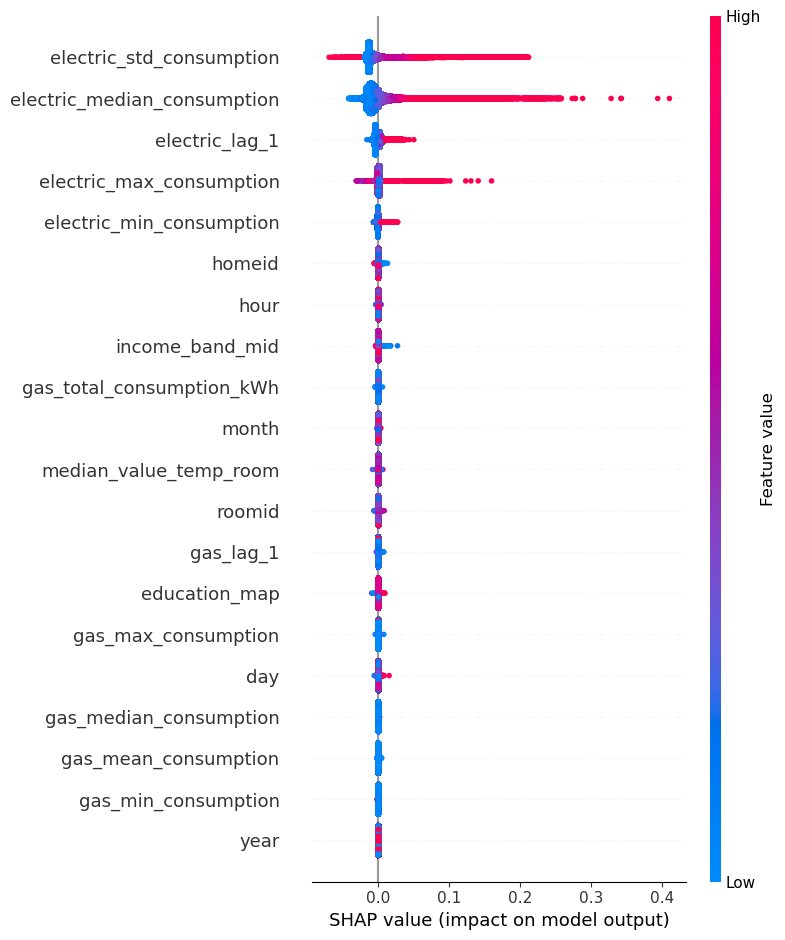

<Figure size 1000x600 with 0 Axes>

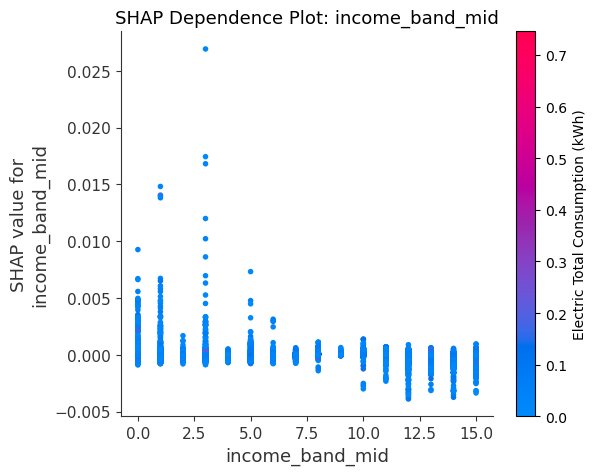

<Figure size 1000x600 with 0 Axes>

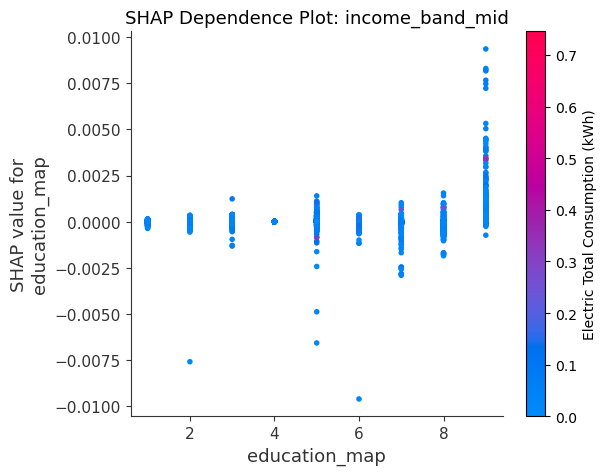


Model: catboost
  Best Validation MSE: 0.0001
  Test Metrics (averaged across folds):
    RMSE: 0.0084
    R2:   0.9550
    MAE:  0.0043
    MSE:  0.0001
  Hyperparameters:
    n_estimators: 30
    learning_rate: 0.1
    max_depth: 10
    reg_lambda: 0


SHAP for catboost:   0%|          | 0/6 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

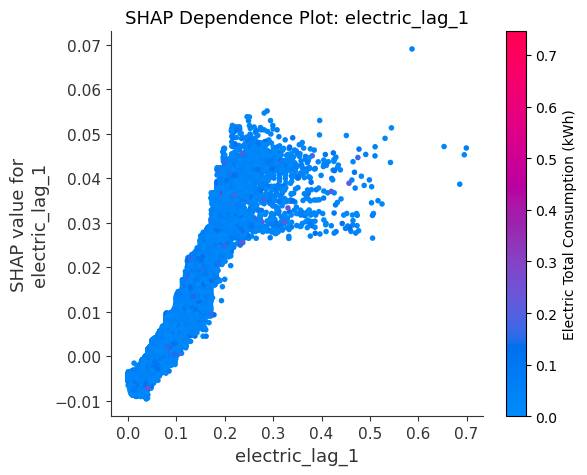

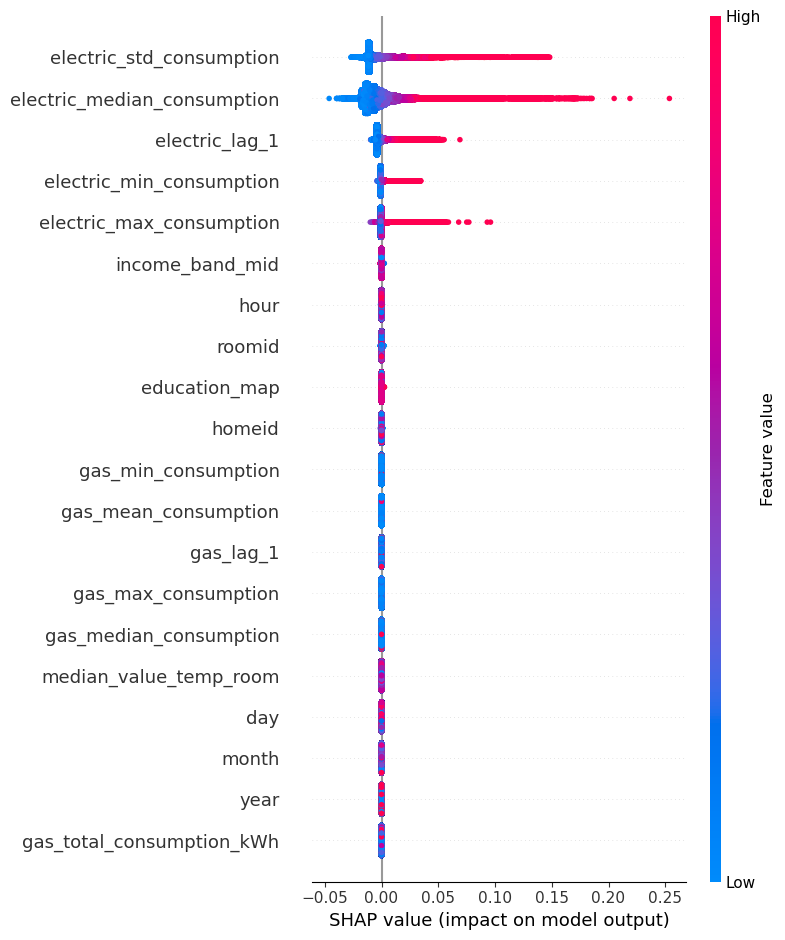

<Figure size 1000x600 with 0 Axes>

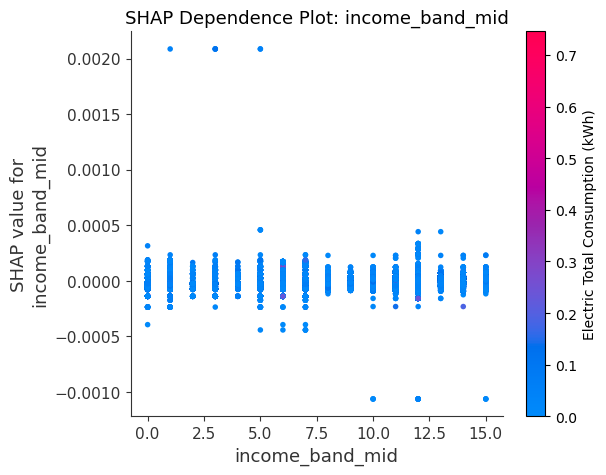

<Figure size 1000x600 with 0 Axes>

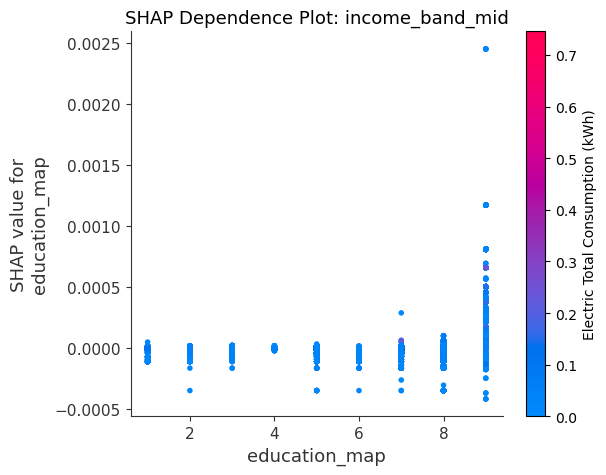

In [23]:
from tqdm.auto import tqdm
import shap
import matplotlib.pyplot as plt
import seaborn as sns
# Split data into train, validation, and test sets 70% train, 15% validation, 15% test
X_temp_elec, X_test_elec, y_temp_elec, y_test_elec = train_test_split(X_elec, y_elec, test_size=0.15, random_state=42)

# Further split train+validation into train and validation sets
X_train_elec, X_val_elec, y_train_elec, y_val_elec = train_test_split(X_temp_elec, y_temp_elec, test_size=0.17647, random_state=42)

# Compare best trials from each separate study
print("\nBest Trials Per Model:")

for model_name, model_study in studies.items():
    if model_name == "randomforest":
        continue  # Skip SHAP for RandomForest due to long runtime
    best_trial = min(model_study.trials, key=lambda t: t.value)
    
    print(f"\nModel: {model_name}")
    print(f"  Best Validation MSE: {best_trial.value:.4f}")
    print("  Test Metrics (averaged across folds):")
    print(f"    RMSE: {best_trial.user_attrs.get('avg_test_rmse', np.nan):.4f}")
    print(f"    R2:   {best_trial.user_attrs.get('avg_test_r2', np.nan):.4f}")
    print(f"    MAE:  {best_trial.user_attrs.get('avg_test_mae', np.nan):.4f}")
    print(f"    MSE:  {best_trial.user_attrs.get('avg_test_mse', np.nan):.4f}")
    print("  Hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    with tqdm(desc=f"SHAP for {model_name}", total=6) as pbar:
        # 1. Re-create the best model from the best trial
        best_params = {k: v for k, v in best_trial.params.items()}
        final_model = MODEL_CONSTRUCTORS[model_name](best_params)
        pbar.update(1)

        # 2. Fit on full train set
        final_model.fit(X_elec, y_elec)
        pbar.update(1)

        # 3. Generate SHAP explanations and plots
        explainer = shap.TreeExplainer(final_model)
        shap_values_elec = explainer.shap_values(X_test_elec)
        pbar.update(1)

        # Create a scatter plot with custom color mapping
        plt.figure(figsize=(10, 6))
        shap.dependence_plot("electric_lag_1", shap_values_elec, X_test_elec, interaction_index=None, show=False)
        scatter = plt.gcf().get_axes()[0].collections[0]
        scatter.set_cmap(shap.plots.colors.red_blue)
        scatter.set_array(y_test_elec)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Electric Total Consumption (kWh)', fontsize=10)
        plt.title('SHAP Dependence Plot: electric_lag_1', fontsize=13)
        plt.show()

        # Show summary plot
        shap.summary_plot(shap_values_elec, X_test_elec)
        pbar.update(1)

        # Scatter plot for income band
        plt.figure(figsize=(10, 6))
        shap.dependence_plot("income_band_mid", shap_values_elec, X_test_elec, interaction_index=None, show=False)
        scatter = plt.gcf().get_axes()[0].collections[0]
        scatter.set_cmap(shap.plots.colors.red_blue)
        scatter.set_array(y_test_elec)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Electric Total Consumption (kWh)', fontsize=10)
        plt.title('SHAP Dependence Plot: income_band_mid', fontsize=13)
        plt.show()
        pbar.update(1)

        # Scatter plot for education map
        plt.figure(figsize=(10, 6))
        shap.dependence_plot("education_map", shap_values_elec, X_test_elec, interaction_index=None, show=False)
        scatter = plt.gcf().get_axes()[0].collections[0]
        scatter.set_cmap(shap.plots.colors.red_blue)
        scatter.set_array(y_test_elec)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Electric Total Consumption (kWh)', fontsize=10)
        plt.title('SHAP Dependence Plot: income_band_mid', fontsize=13)
        plt.show()

        pbar.update(1)


Best Trials Per Model:

Model: lightgbm
  Best Validation MSE: 0.0000
  Test Metrics (averaged across folds):
    RMSE: 0.0016
    R2:   0.9889
    MAE:  0.0005
    MSE:  0.0000
  Hyperparameters:
    n_estimators: 40
    learning_rate: 0.1
    max_depth: 7
    reg_lambda: 10


SHAP for lightgbm:   0%|          | 0/7 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

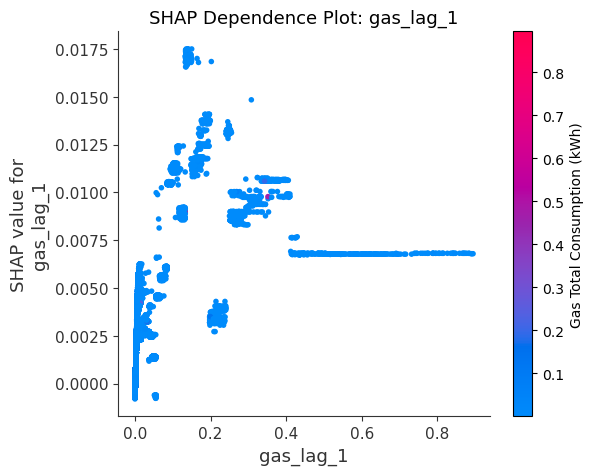

<Figure size 1000x600 with 0 Axes>

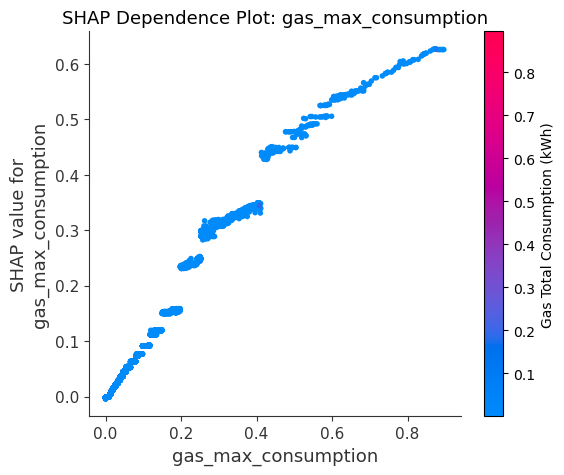

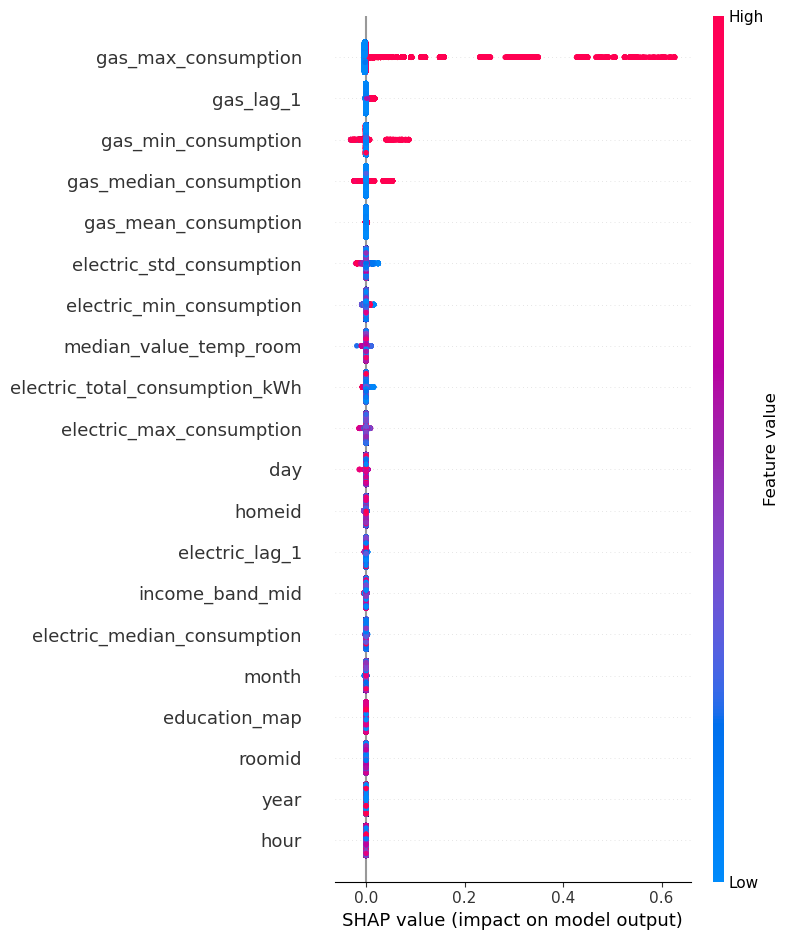

<Figure size 1000x600 with 0 Axes>

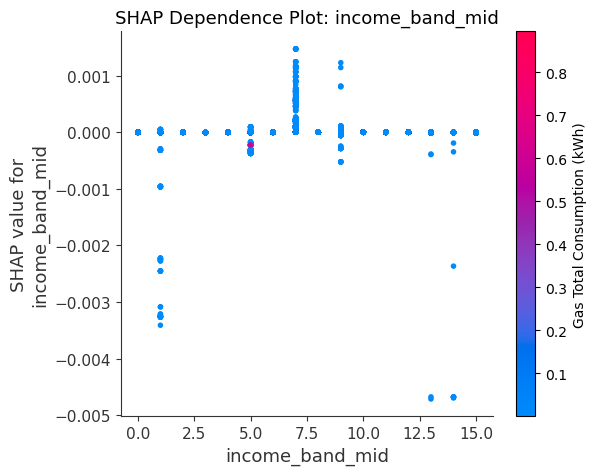

<Figure size 1000x600 with 0 Axes>

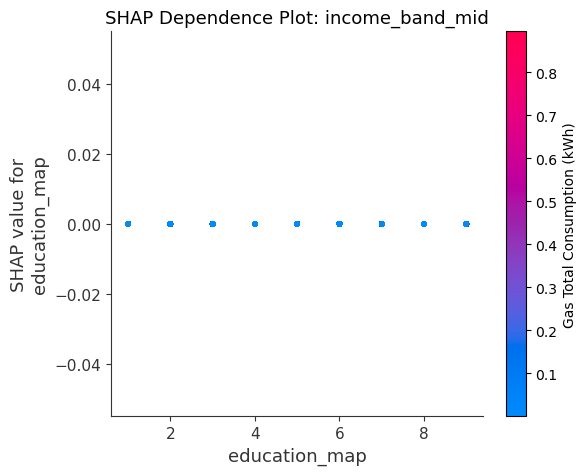


Model: xgboost
  Best Validation MSE: 0.0000
  Test Metrics (averaged across folds):
    RMSE: 0.0023
    R2:   0.9737
    MAE:  0.0006
    MSE:  0.0000
  Hyperparameters:
    n_estimators: 40
    learning_rate: 0.1
    max_depth: 3
    reg_lambda: 0


SHAP for xgboost:   0%|          | 0/7 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

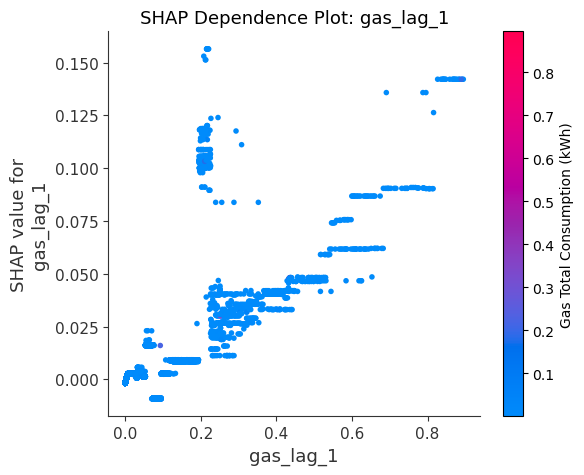

<Figure size 1000x600 with 0 Axes>

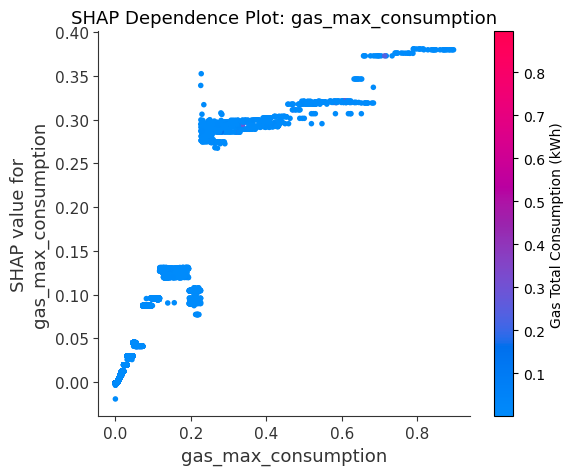

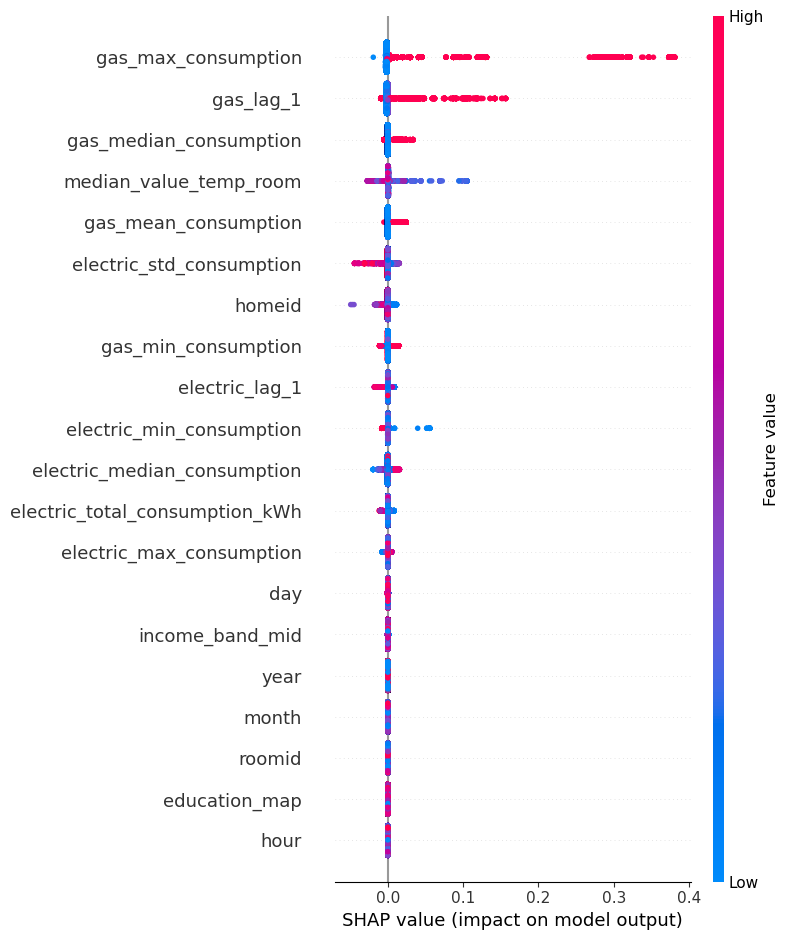

<Figure size 1000x600 with 0 Axes>

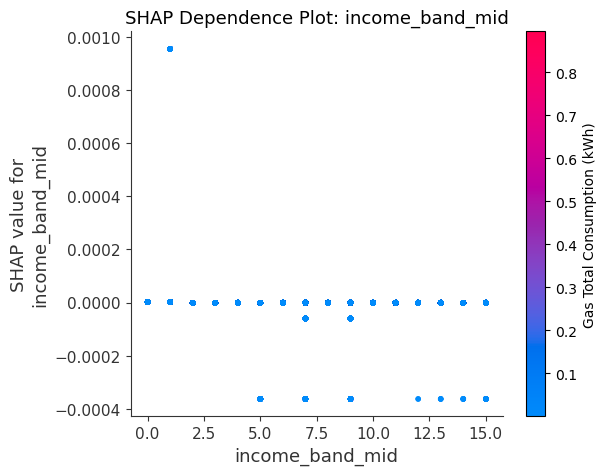

<Figure size 1000x600 with 0 Axes>

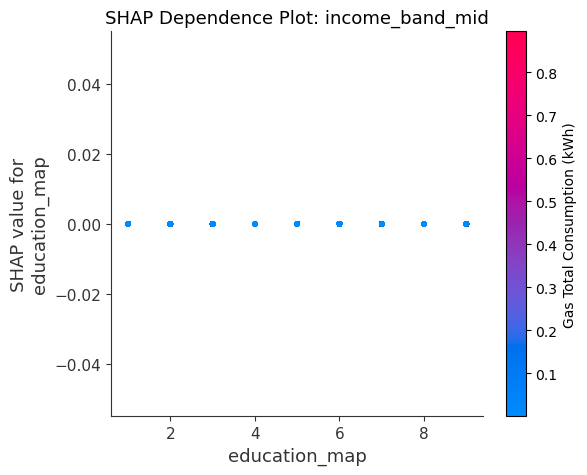


Model: catboost
  Best Validation MSE: 0.0000
  Test Metrics (averaged across folds):
    RMSE: 0.0019
    R2:   0.9834
    MAE:  0.0007
    MSE:  0.0000
  Hyperparameters:
    n_estimators: 40
    learning_rate: 0.1
    max_depth: 3
    reg_lambda: 1


SHAP for catboost:   0%|          | 0/7 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

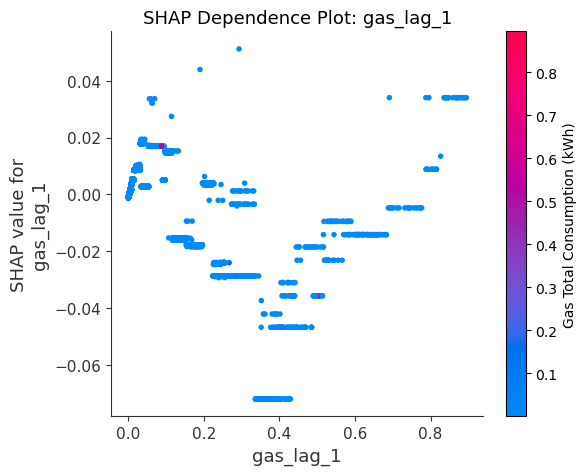

<Figure size 1000x600 with 0 Axes>

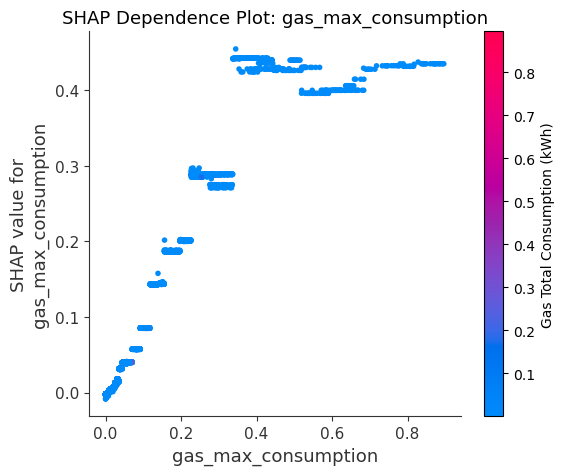

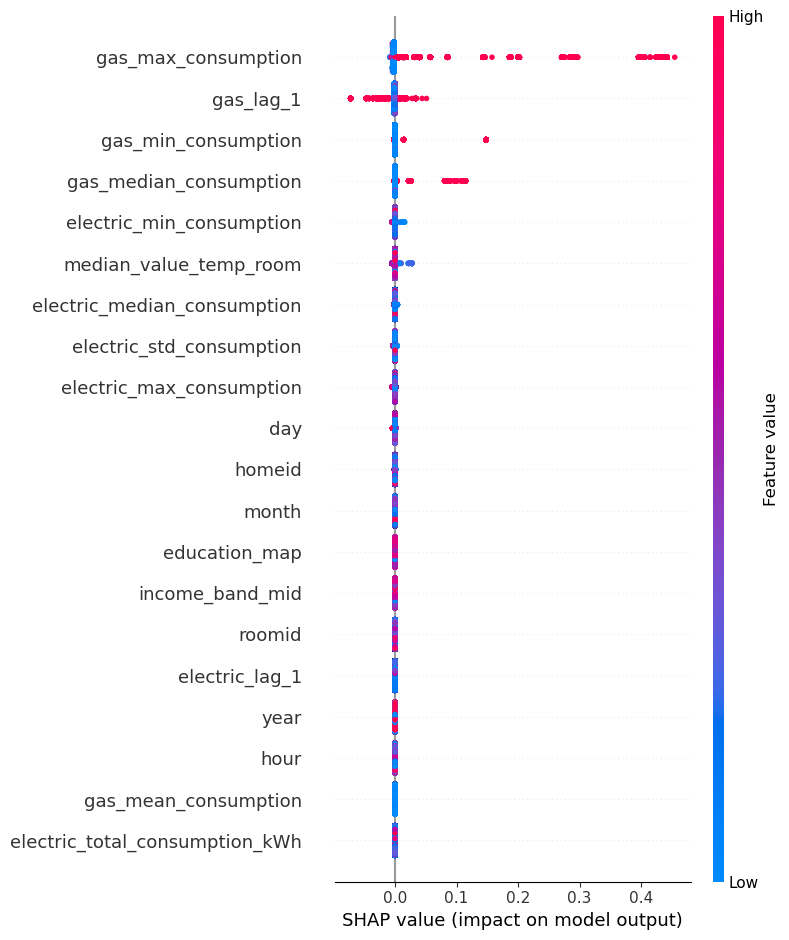

<Figure size 1000x600 with 0 Axes>

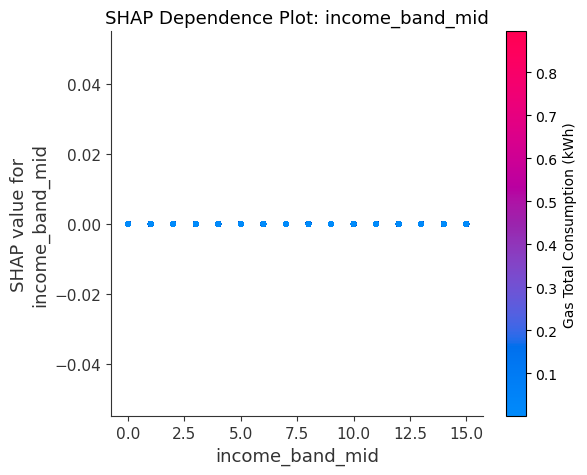

<Figure size 1000x600 with 0 Axes>

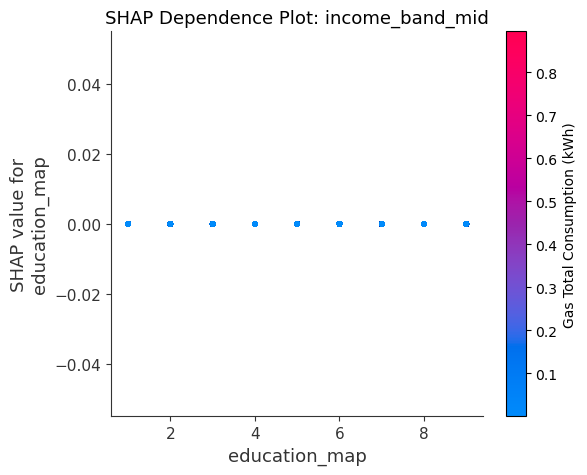

In [26]:
from tqdm.auto import tqdm
# Split data into train, validation, and test sets 70% train, 15% validation, 15% test
X_temp_gas, X_test_gas, y_temp_gas, y_test_gas = train_test_split(X_gas, y_gas, test_size=0.15, random_state=42)

# Further split train+validation into train and validation sets
X_train_gas, X_val_gas, y_train_gas, y_val_gas = train_test_split(X_temp_gas, y_temp_gas, test_size=0.17647, random_state=42)

# Compare best trials from each separate study
print("\nBest Trials Per Model:")

for model_name, model_study in studies2.items():
    if model_name == "randomforest":
        continue  # Skip SHAP for RandomForest due to long runtime
    best_trial2 = min(model_study.trials, key=lambda t: t.value)
    
    print(f"\nModel: {model_name}")
    print(f"  Best Validation MSE: {best_trial2.value:.4f}")
    print("  Test Metrics (averaged across folds):")
    print(f"    RMSE: {best_trial2.user_attrs.get('avg_test_rmse', np.nan):.4f}")
    print(f"    R2:   {best_trial2.user_attrs.get('avg_test_r2', np.nan):.4f}")
    print(f"    MAE:  {best_trial2.user_attrs.get('avg_test_mae', np.nan):.4f}")
    print(f"    MSE:  {best_trial2.user_attrs.get('avg_test_mse', np.nan):.4f}")
    print("  Hyperparameters:")
    for key, value in best_trial2.params.items():
        print(f"    {key}: {value}")

    with tqdm(desc=f"SHAP for {model_name}", total=7) as pbar:
        # 1. Re-create the best model from the best trial
        best_params = {k: v for k, v in best_trial2.params.items()}
        final_model2 = MODEL_CONSTRUCTORS[model_name](best_params)
        pbar.update(1)

        # 2. Fit on your full dataset or a final train set
        final_model2.fit(X_gas, y_gas)
        pbar.update(1)

        # 3. Generate SHAP explanations and plots
        explainer = shap.TreeExplainer(final_model2)
        shap_values_gas = explainer.shap_values(X_test_gas)
        pbar.update(1)

        # Create a scatter plot for lag_1 values
        plt.figure(figsize=(10, 6))
        shap.dependence_plot("gas_lag_1", shap_values_gas, X_test_gas, interaction_index=None, show=False)
        scatter = plt.gcf().get_axes()[0].collections[0]
        scatter.set_cmap(shap.plots.colors.red_blue)
        scatter.set_array(y_test_gas)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Gas Total Consumption (kWh)', fontsize=10)
        plt.title('SHAP Dependence Plot: gas_lag_1', fontsize=13)
        plt.show()

        # Create a scatter plot for max_consumption
        plt.figure(figsize=(10, 6))
        shap.dependence_plot("gas_max_consumption", shap_values_gas, X_test_gas, interaction_index=None, show=False)
        scatter = plt.gcf().get_axes()[0].collections[0]
        scatter.set_cmap(shap.plots.colors.red_blue)
        scatter.set_array(y_test_gas)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Gas Total Consumption (kWh)', fontsize=10)
        plt.title('SHAP Dependence Plot: gas_max_consumption', fontsize=13)
        plt.show()
        pbar.update(1)

        # Show summary plot
        shap.summary_plot(shap_values_gas, X_test_gas)
        pbar.update(1)

        # Scatter plot for income band
        plt.figure(figsize=(10, 6))
        shap.dependence_plot("income_band_mid", shap_values_gas, X_test_gas, interaction_index=None, show=False)
        scatter = plt.gcf().get_axes()[0].collections[0]
        scatter.set_cmap(shap.plots.colors.red_blue)
        scatter.set_array(y_test_gas)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Gas Total Consumption (kWh)', fontsize=10)
        plt.title('SHAP Dependence Plot: income_band_mid', fontsize=13)
        plt.show()
        pbar.update(1)

        # Scatter plot for education map
        plt.figure(figsize=(10, 6))
        shap.dependence_plot("education_map", shap_values_gas, X_test_gas, interaction_index=None, show=False)
        scatter = plt.gcf().get_axes()[0].collections[0]
        scatter.set_cmap(shap.plots.colors.red_blue)
        scatter.set_array(y_test_gas)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Gas Total Consumption (kWh)', fontsize=10)
        plt.title('SHAP Dependence Plot: income_band_mid', fontsize=13)
        plt.show()

        pbar.update(1)